<a href="https://colab.research.google.com/github/woodstone10/deep_learning_study-python/blob/main/NLP_spam_email.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Spam email classification using CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

---
https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", \
                           filename='spam.csv')
data = pd.read_csv('spam.csv', encoding='latin-1')
print(len(data))
data.head()

5572


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
print(list(data['v1']))

['ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', '

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

From above, two cases, ham or spam

In [6]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'], [0,1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data.drop_duplicates(subset=['v2'], inplace=True)
print(len(data))

5169


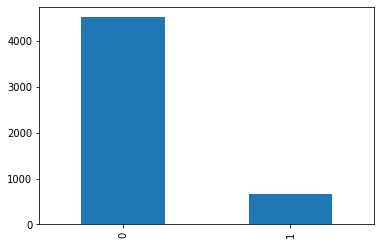

In [8]:
data['v1'].value_counts().plot(kind='bar')

In [9]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


## NLP data pre-processing

**tokenization and sequencing**

In [10]:
X_data = data['v2']
y_data = data['v1']

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [12]:
X_data = sequences
print('max length: {}'.format(max(len(l) for l in X_data)))
print('mean length: {}'.format((sum(map(len, X_data))/len(X_data))))

max length: 172
mean length: 12.566840781582512


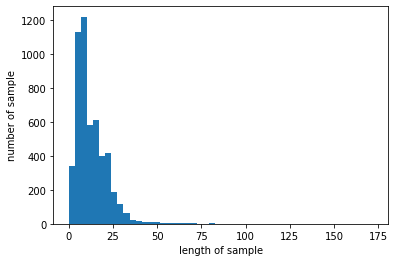

In [13]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

**padding**

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 60
data = pad_sequences(X_data, maxlen=max_len)
print(data.shape)

(5169, 60)


**train and test data**

In [15]:
n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)
print(n_train)
print(n_test)

4135
1034


In [16]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])
X_test = data[n_train:]
y_test = np.array(y_data[n_train:])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


## Model

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

same model with above, just another method for keras high-level API

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 32),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv1D(32, 5, strides=1, padding='valid', activation='relu'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

**early-stopping**

In [22]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=3)
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_acc',
                     mode='max',
                     verbose=1,
                     save_best_only=True)

## Train

In [24]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train,
                      y_train, 
                      epochs=10,
                      batch_size=64,
                      validation_split=0.2,
                      callbacks=[es, mc])

Epoch 1/10
52/52 [==============================] - 33s 12ms/step - loss: 0.5602 - acc: 0.8617 - val_loss: 0.3848 - val_acc: 0.8730

Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
Epoch 2/10
52/52 [==============================] - 0s 6ms/step - loss: 0.3982 - acc: 0.8629 - val_loss: 0.3675 - val_acc: 0.8730

Epoch 00002: val_acc did not improve from 0.87304
Epoch 3/10
52/52 [==============================] - 0s 5ms/step - loss: 0.3473 - acc: 0.8641 - val_loss: 0.1798 - val_acc: 0.9637

Epoch 00003: val_acc improved from 0.87304 to 0.96372, saving model to best_model.h5
Epoch 4/10
52/52 [==============================] - 0s 5ms/step - loss: 0.1325 - acc: 0.9692 - val_loss: 0.0636 - val_acc: 0.9831

Epoch 00004: val_acc improved from 0.96372 to 0.98307, saving model to best_model.h5
Epoch 5/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0682 - acc: 0.9815 - val_loss: 0.0523 - val_acc: 0.9831

Epoch 00005: val_acc did not improve from

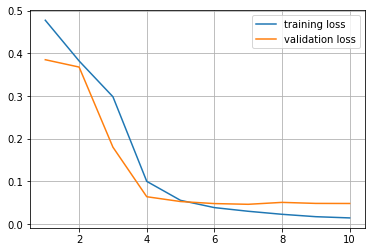

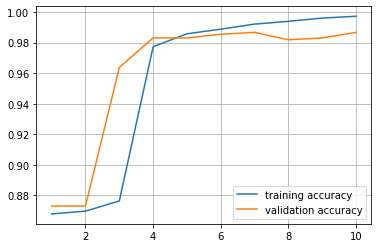

In [27]:
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()
plt.grid()
plt.show()

## Evaluate

In [28]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 3ms/step - loss: 0.0653 - acc: 0.9826


[0.06532332301139832, 0.9825918674468994]